# INVESTMENT PORTFOLIO OPTIMIZATION

**PROBLEM STATEMENT**

Given a portfolio of stocks, the holdings/weights need to balanced/rebalanced in such a way that they match the weights that would match the optimal weights.

**SOLUTION**

We will be solving this problem using two approaches namely, Monte Carlo based brute force approach and another using Scipy's minimize function based on various cost functions (the Sharpe Ratio, the Variance, the Value at Risk).

### TASK 1 : Using cost fucntions SHARPE RATIO and VARIANCE

We will create a portfolio of **5 stocks** and run **100,000 simulated portfolios** to produce our results. These results will then be plotted and both the **optimal portfolio** with the highest recorded Sharpe ratio and the **minimum variance portfolio** will be highlighted.

We start by importing the required modules

In [1]:
import pandas as pd  
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

We then choose any 5 stocks, download their price data and convert the same into a dataframe.

In [2]:
tickers = ['AAPL', 'MSFT', 'NFLX', 'AMZN', 'GOOG']
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2018, 12, 31)
df = pd.DataFrame([data.DataReader(ticker, 'yahoo', start, end)['Adj Close'] for ticker in tickers]).T
df.columns = tickers

**Optimization Method 1 : Monte Carlo based Brute Force Approach** 

We will be creating a large number of random portfolios all with varying combinations of constituent stock weights, calculating and recording the Sharpe ratio of each of the randomly weighted portfolio and then finally extracting the details corresponding to the result with the heighest value.

The function **calculate_portfolio_performance** calculates the following :
1. Annualised return
2. Annualised standard deviation
3. Annualised Sharpe ration of a portfolio 

The parameters the function takes are :
1. Weight of the portfolio constitiuents
2. Mean daily return of each of those constituents
3. Covarience matrix of the constituents
4. Risk free interst rate

In [3]:
# in this function wherever '252' is used, it represents a year's worth of trading days 
def calculate_portfolio_performance(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252 
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

The function **simulate_random_portfolios** deals with the overall creation of multiple randomly weights portfolios taking the same parameters as the above function. 

In [4]:
def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns) + 3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calculate_portfolio_performance(weights, mean_returns, cov, rf)
        
        results_matrix[0, i] = portfolio_return
        results_matrix[1, i] = portfolio_std
        results_matrix[2, i] = sharpe_ratio
        
        # iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j + 3, i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns = ['ret', 'stdev', 'sharpe'] + [ticker for ticker in tickers])
    return results_df

Now, mean returns and co-variance matrix is calculated.

In [5]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000 
rf = 0.0 # we take te risk free rate = 0
results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

Let's now visualise the results of all the simulated portfolios, plotting each portfolio by it's corresponding values of the annalised return (y-axis) and annualised volatility (x-axis).

Maximum Sharp Ratio Portfolio is marked with red star an the Minimum Variance Portfolio with marked with green star.

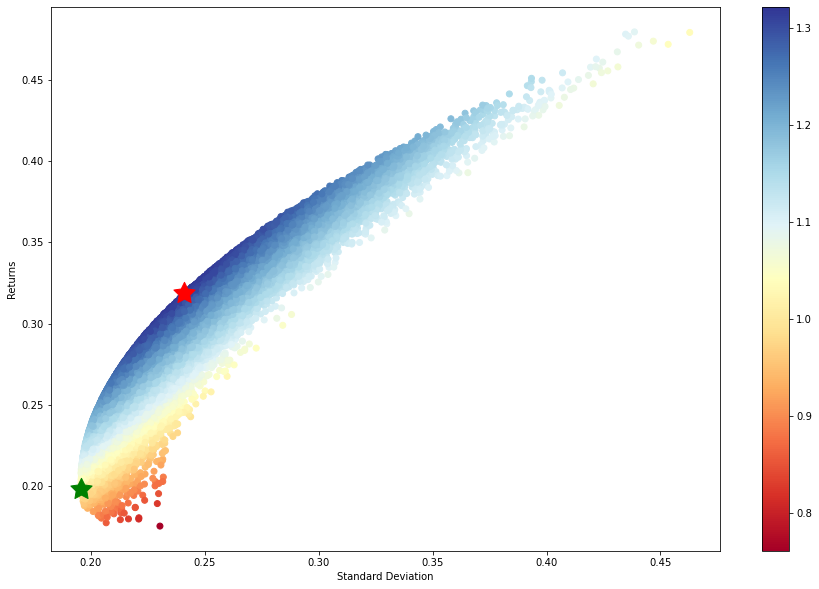

In [6]:
# locate position of portfolio with highest Sharpe Ratio
max_sharpe_portfolio = results_frame.iloc[results_frame['sharpe'].idxmax()]

# locate positon of portfolio with minimum standard deviation
min_variance_portfolio = results_frame.iloc[results_frame['stdev'].idxmin()]

# create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize = (15,10))
plt.scatter(results_frame.stdev, results_frame.ret, c = results_frame.sharpe, cmap = 'RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

# plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_portfolio[1], max_sharpe_portfolio[0], marker = (5,1,0), color = 'r', s = 500)

# plot green star to highlight position of minimum variance portfolio
plt.scatter(min_variance_portfolio[1], min_variance_portfolio[0], marker = (5,1,0), color = 'g', s = 500)

plt.show()

In [7]:
max_sharpe_portfolio.to_frame().T

,ret,stdev,sharpe,AAPL,MSFT,NFLX,AMZN,GOOG
37906,0.31854,0.241112,1.32113,0.338748,0.155082,0.231377,0.274107,0.000686


In [8]:
min_variance_portfolio.to_frame().T

,ret,stdev,sharpe,AAPL,MSFT,NFLX,AMZN,GOOG
35993,0.197905,0.195689,1.011323,0.286114,0.404493,0.00921,0.015568,0.284615


**Optimization Method 2: Using Scipy 'minimize' function**

Scipy offers a minimize function but no maximize function, hence if we wish to maximize the Sharpe Ratio, we need to minimize the negative of Sharpe ratio. Hence we firstly, define a function that calculates the negative Sharpe ration of a portfolio.

In [9]:
def calculate_negative_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

We will be using **SLSQP method** in our minimize function i.e, Sequential Least Squares Programming with the arguements "type" and "fun".  

We have taken the "type" as "eq" referring to equality and "fun" refers to function defining the constraingt, in our case the constraint that the sum of the stock weights must be 1.

In [10]:
def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calculate_negative_sharpe, num_assets * [1./num_assets,], args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)
    return result

In [11]:
optimal_portfolio_sharpe = max_sharpe_ratio(mean_returns, cov, rf)

When we run the optimization, we get the following results :

In [12]:
pd.DataFrame([round(x, 2) for x in optimal_portfolio_sharpe['x']],index = tickers).T

,AAPL,MSFT,NFLX,AMZN,GOOG
0,0.35,0.15,0.23,0.27,0.0


The results look similar to the one given by Monte Carlo appraoch.   

Now, we need to identify the minimum variance portfolio. We define a fucntion to calculate and return the volatility of a portfolio. This time there is no need to negate the output of our function as it is already a minimisation problem this time (as opposed to the Sharpe ratio when we wanted to find the maximum).

In [13]:
def calculate_portfolio_std(weights, mean_returns, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std

In [14]:
def min_variance(mean_returns, cov):
    num_assets = len(mean_returns)
    args = (mean_returns, cov)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calculate_portfolio_std, num_assets * [1./num_assets,], args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)
    return result

In [15]:
min_portfolio_variance = min_variance(mean_returns, cov)

When we run the optimization, we get the following results : 

In [16]:
pd.DataFrame([round(x, 2) for x in min_portfolio_variance['x']],index = tickers).T

,AAPL,MSFT,NFLX,AMZN,GOOG
0,0.28,0.4,0.02,0.03,0.27


Again we see the results are very close to those we were presented with when using the Monte Carlo approach.

### TASK 2 : Using the cost function VALUE AT RISK (VaR)

Our next task is to **identify the portfolio weights** that **minimize the Value at Risk (VaR)**. 

**Optimization Method 1 : Brute force style Monte Carlo Approach** 

 The following function is similar to calculate_portfolio_performance, only difference is that this one has two more variable parameters **alpha** and **days**. This function returns the parametric portfolio VaR to a confidence level determined by the value of the alpha arguement **(confidence level is 1 - alpha)** and to a time scale determined by the days arguement.

In [17]:
def calculate_portfolio_performance_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_var

In [22]:
def simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days):
    results_matrix = np.zeros((len(mean_returns) + 3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, portfolio_VaR = calculate_portfolio_performance_VaR(weights, mean_returns, cov, alpha, days)
        
        results_matrix[0, i] = portfolio_return
        results_matrix[1, i] = portfolio_std
        results_matrix[2, i] = portfolio_VaR
        
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j + 3, i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T, columns = ['ret', 'stdev', 'VaR'] + [ticker for ticker in tickers])
        
    return results_df

Now we have chosen 252 days (to represent a year’s worth of trading days) and an alpha of 0.05, corresponding to a 95% confidence level. So that is to say we will be calculating the one-year 95% VaR, and attempting to minimise that value.

In [23]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0
days = 252
alpha = 0.05
results_frame = simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days)

This time we plot the results of each portfolio with **annualised return remaining** on the y-axis but the x-axis this time representing the **portfolio VaR** (rather than standard deviation).

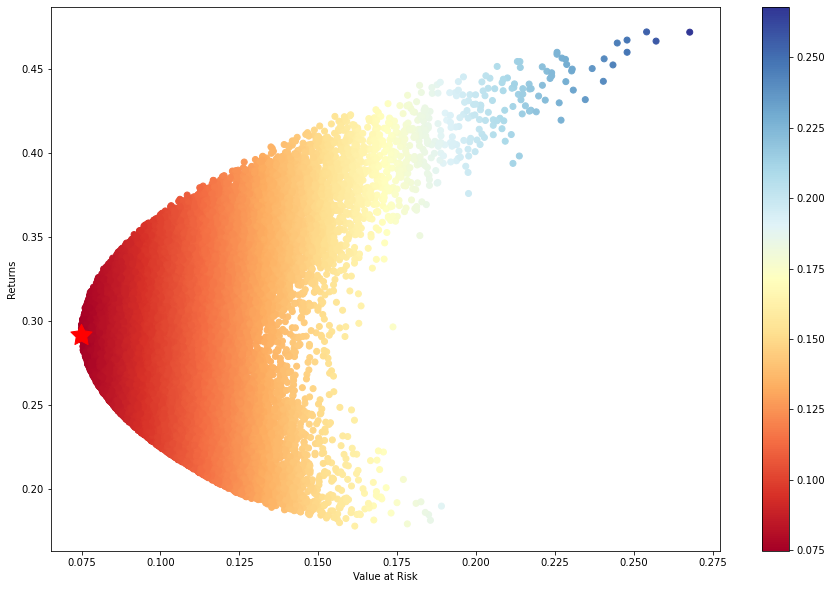

In [24]:
# locate positon of portfolio with minimum VaR
min_VaR_portfolio = results_frame.iloc[results_frame['VaR'].idxmin()]

# create scatter plot coloured by VaR
plt.subplots(figsize = (15,10))
plt.scatter(results_frame.VaR, results_frame.ret, c = results_frame.VaR, cmap = 'RdYlBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()

# plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_portfolio[2], min_VaR_portfolio[0], marker = (5,1,0), color = 'r', s = 500)
plt.show()

The weights of the resulting minimum VaR portfolio is as shown below.

In [25]:
min_VaR_portfolio.to_frame().T

,ret,stdev,VaR,AAPL,MSFT,NFLX,AMZN,GOOG
76099,0.29147,0.222693,0.074826,0.342548,0.249006,0.169909,0.232073,0.006464


Plotting the location of the minimum VaR portfolio on a chart with the y-axis as return and the x-axis as standard deviation.

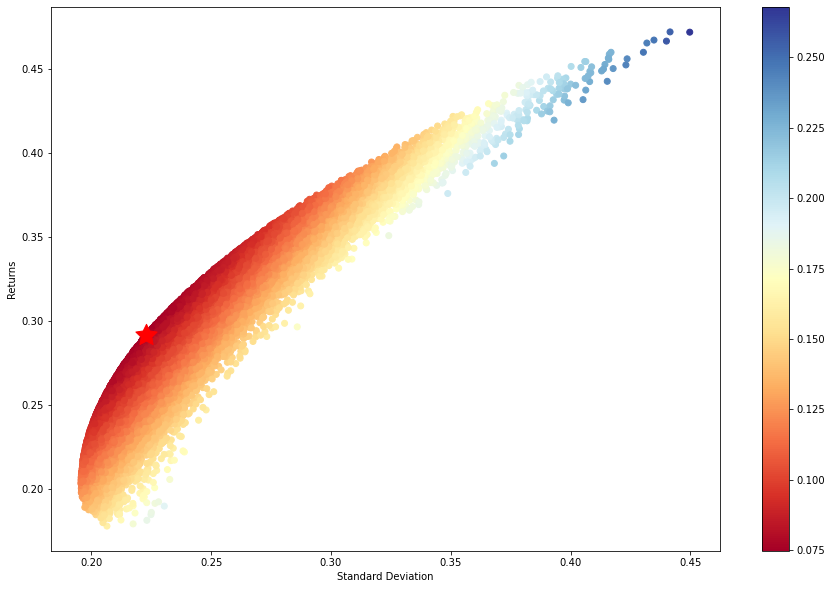

In [26]:
# locate positon of portfolio with minimum VaR
min_VaR_portfolio = results_frame.iloc[results_frame['VaR'].idxmin()]

# create scatter plot coloured by VaR
plt.subplots(figsize = (15,10))
plt.scatter(results_frame.stdev, results_frame.ret,c = results_frame.VaR, cmap = 'RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

# plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_portfolio[1], min_VaR_portfolio[0], marker = (5,1,0), color = 'r', s = 500)
plt.show()

At this point, it can be clearly seen that the results of the minimum VaR portfolio simulations look pretty similar to those of the maximum Sharpe ratio portfolio and thsi was expected considering the calculation method chosen for VaR.

The VaR calculation was :

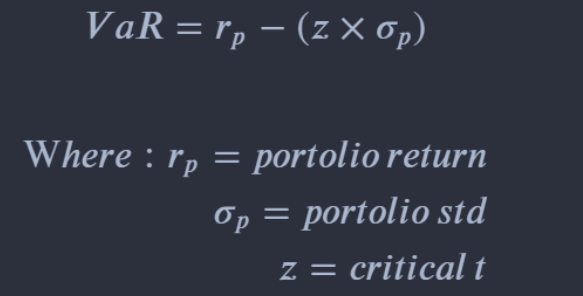

And the calculation of the Sharpe ratio was:

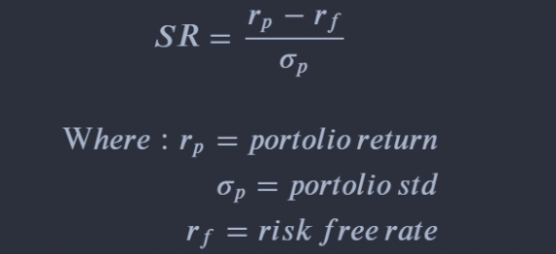

From this we can see that VaR falls when portfolio returns increase and vice versa, whereas the Sharpe ratio increases as portfolio returns increase – so what minimises VaR in terms of returns actually maximises the Sharpe ratio.  

Similarly, an increase in portfolio standard deviation increases VaR but decreases the Sharpe ratio – so what maximises VaR in terms of portfolio standard deviation actually minimises the Sharpe ratio.

**Optimization Method 2: Using Scipy 'minimize' function**

We need a new function that calculates and returns just the VaR of a portfolio. We return portfolio VaR unlike previous task where we returned portfolio standard deviation.


In [27]:
def calculate_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

The "min_VaR" function acts much as the "max_sharpe_ratio" and "min_variance" functions did, just with some tweaks to alter the arguments as needed. The constraints are the same, as are the bounds etc.

In [28]:
def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calculate_portfolio_VaR, num_assets*[1./num_assets,], args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)
    return result

In [29]:
min_portfolio_VaR = min_VaR(mean_returns, cov, alpha, days)

When we run the optimisation, we get the following results:

In [30]:
pd.DataFrame([round(x,2) for x in min_portfolio_VaR['x']],index=tickers).T

,AAPL,MSFT,NFLX,AMZN,GOOG
0,0.35,0.24,0.18,0.23,0.0
